# Podcast Editing pt1 - Removing Silence
I will first try to detect and remove periods of silence based on a noise window. 

In [1]:
from a3py import *
import scipy as sp

### Let's grab some audio...


Input Audio File ./media/diggy_silences_short.wav:


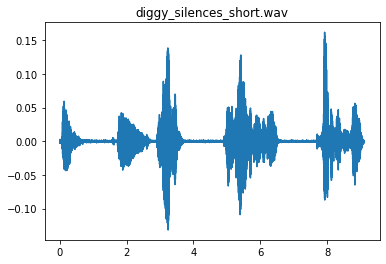

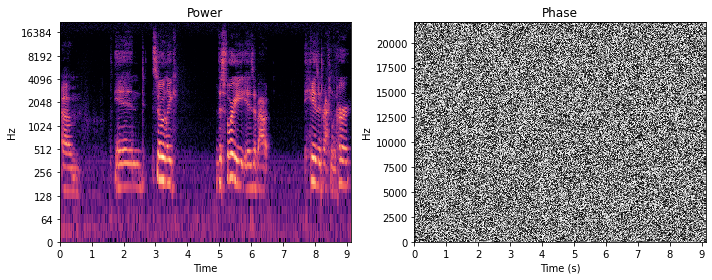

In [5]:
audio_file_path = './media/diggy_silences_short.wav';

a = Audio(audio_file_path);
print("Input Audio File {}:".format(audio_file_path));
a.play()
a.plot();
stft = STFT.FromAudio(a);
stft.show()